# Stochastic Gradient Langevin Dynamics Method

## 0. Import

In [1]:
using Random
using Distributions
using Statistics
using ForwardDiff
using LinearAlgebra
using ProgressMeter
using Plots
pyplot()

Plots.PyPlotBackend()

## 1. functions

In [2]:
#initialize the parameter
function init_params(Dx, D₀, Dy)
    W₂ = rand(D₀, Dx)
    W₃ = rand(Dy, D₀)
    b₂ = zeros(D₀)
    b₃ = zeros(Dy)
    return W₂, W₃, b₂, b₃
end

#stick the weights and biases to a large matrix
function stick_params(W₂, W₃, b₂, b₃)
    tmp1 = vcat(b₂', W₂')
    tmp2 = hcat(tmp1, zeros(Dx+1))
    tmp3 = hcat(W₃, b₃)
    return vcat(tmp2, tmp3)
end

#devide the paramters vector to weights and biases
function reshape_params(params_vec, Dx, D₀, Dy)
    W = reshape(params_vec, (Dx+Dy+1, D₀+1))
    W₂ = view(W, 2:Dx+1, 1:D₀)'
    W₃ = view(W, Dx+2:Dx+Dy+1, 1:D₀)
    b₂ = view(W, 1, 1:D₀)
    b₃ = view(W, Dx+2:Dx+Dy+1, D₀+1)
    return W₂, W₃, b₂, b₃
end 

#sigmoid function
σ(ξ) = 1/(1+exp(-ξ)) 

#Neural Network
function Φ(x, params_vec, Dx, D₀, Dy)
    W₂, W₃, b₂, b₃ = reshape_params(params_vec, Dx, D₀, Dy)
    return σ.(W₃*σ.(W₂*x+b₂) + b₃)
end

#prior, model, posterior, liklihood
logpprior(wvec, λw) = logpdf(MvNormal(zeros(length(wvec)), 1/√λw), wvec)
logpmodel(y, x, wvec, Φ) = log(dot(y, Φ(x,wvec))/sum(Φ(x,wvec)))
loglik(wvec, Φ, X, Y, N) = sum([logpmodel(Y[:,n], X[:,n], wvec, Φ) for n in 1:N])
logppost(wvec, λw, Φ, X, Y, N) = sum(logpprior(wvec,λw)) + loglik(wvec, Φ, X, Y, N)

#predictive: returns the probability to new data classify to class 1
function ppred(x, wsamps, pmodel)
    _,n_samps = size(wsamps)
    preds = zeros(n_samps)
    for i in 1:n_samps
        preds[i] = pmodel([1,0], x, wsamps[:,i])
    end
    return mean(preds)
end

#plot the data and return the figure
function plot_data(X, Y)
    _,N = size(X)
    fig = plot(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, title="data", legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

function plot_data(fig, X, Y)
    _,N = size(X)
    fig = plot!(xticks=0:0.2:1, xlim=[0,1], yticks=0:0.2:1, ylim=[0,1], aspect_ratio=:equal, legend=false)
    for k in 1:N
        if Y[1,k]==1
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:circle, markersize=10, color="red")
        else
            plot!([X[1,k]], [X[2,k]], st=:scatter, markershape=:x, markersize=10, color="blue")
        end
    end
    return fig
end

#plot the probability to classify new data to class 1(red point)
function plot_prob_1(X, Y, pred_func, title)
    T = 50
    X1s = range(0,1,length=T)
    X2s = range(0,1,length=T)
    preds = zeros(T,T)
    @showprogress for j in 1:T
        x2 = X2s[j]
        for i in 1:T
            x1 = X1s[i]
            preds[i,j] = pred_func([x1,x2])
        end
    end
    fig = heatmap(X1s, X2s, preds, c=cgrad(:coolwarm), alpha=0.6, title=title)
    return plot_data(fig, X, Y)
end

plot_prob_1 (generic function with 1 method)

## 2. create the data

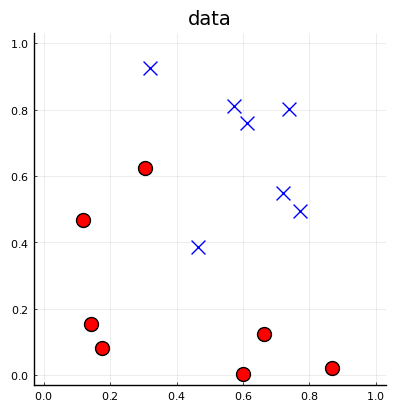

Φ (generic function with 2 methods)

In [3]:
#create the data
Random.seed!(46)
N = 14
X = hcat(rand(Beta(1.1,3), 2, div(N,2)), rand(Beta(1.9,1.1), 2, div(N,2)))
Y = vcat(vcat(ones(div(N,2)), zeros(div(N,2)))', vcat(zeros(div(N,2)), ones(div(N,2)))')

#plot the data
fig1 = plot_data(X, Y)
savefig(fig1, "figs-SGLDM/fig1.png")

#initialize the parameters
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]
d = length(wvec₀)

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

## 3. Stochastic gradient Langevin dynamics method

In [4]:
#MH acceptance and rejection
function accept_or_reject(xvec, xvec_old, pvec, pvec_old, H)
    ΔH = H(xvec, pvec)-H(xvec_old, pvec_old)
    α = min(1.0, exp(-ΔH))
    u = rand()
    if u≤α
        return xvec, pvec
    else
        return xvec_old, pvec_old
    end
end

#Hamiltonian Monte Carlo
function mySGLDM(X, Y, wvec₀, λw, n_samps, n_burnin, logpmodel, logpprior, logppost)
    #initialization
    _, N = size(X)
    d = length(wvec₀)
    wsamps = zeros(d, n_samps)
    wsamps[:,1] = wvec₀
    wvec = zeros(d)
    
    #hamiltonian and gradient
    ∇logpprior(wvec) = ForwardDiff.gradient(wvec->logpprior(wvec, λw), wvec)
    ∇logpmodel(y,x,wvec) = ForwardDiff.gradient(wvec->logpmodel(y,x,wvec), wvec)
    H(wvec, pvec) = -logppost(wvec, λw) + norm(pvec)^2/2
    
    #sample
    wvec_old = wvec₀
    pvec_old = randn(d)
    @showprogress for k in 2:n_samps
        #randomly choose the data
        idx = rand(1:N)
        x = X[:,idx]
        y = Y[:,idx]
        
        #update
        pvec = randn(d)
        αk = 0.1/k
        wvec = wvec + αk*(N*∇logpmodel(y,x,wvec) + ∇logpprior(wvec))/2 + √αk*pvec
        wvec, pvec = accept_or_reject(wvec, wvec_old, pvec, pvec_old, H)
        wsamps[:,k] = wvec
        wvec_old = wvec
        pvec_old = pvec
    end
    return wsamps[:,n_burnin:end]
end

#calculate WAIC
function calc_WAIC(X, Y, wsamps, logpmodel)
    pmodel(y, x, wvec) = exp(logpmodel(y, x, wvec))
    _,N = size(X)
    _,n_samps = size(wsamps)
    logpreds = zeros(N)
    vars = zeros(N)
    for n in 1:N
        logpreds[n] = -log(mean([pmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps]))
        vars[n] = var([logpmodel(Y[:,n], X[:,n], wsamps[:,i]) for i in 1:n_samps])
    end
    return mean(logpreds) + mean(vars)
end

#model selection
function model_selection(X, Y, λws, n_samps, n_burnin, logpmodel, logpprior, logppost)
    M = length(λws)
    WAICs = zeros(M)
    for i in 1:M
        wsamps = mySGLDM(X, Y, wvec₀, λws[i], n_samps, n_burnin, logpmodel, logpprior, logppost)
        WAICs[i] = calc_WAIC(X, Y, wsamps, logpmodel)
    end
    return WAICs
end

model_selection (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


λw=2.0408163265306127 minimize WAIC (std=0.6999999999999998).


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


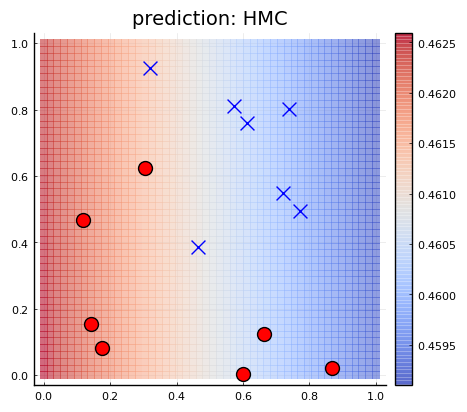

In [5]:
#initialize the parameters
Random.seed!(42)
Dx, N = size(X)
Dy, N = size(Y)
D₀ = 5
W₂, W₃, b₂, b₃ = init_params(Dx, D₀, Dy)
Ws = stick_params(W₂, W₃, b₂, b₃)
wvec₀ = Ws[:]

#Neural Network 
Φ(x, wvec) = Φ(x, wvec, Dx, D₀, Dy) 

#prior, model, posterior, predictive
logpmodel(y, x, wvec) = logpmodel(y, x, wvec, Φ)
pmodel(y,x,wvec) = exp(logpmodel(y,x,wvec))
logppost(wvec, λw) = logppost(wvec, λw, Φ, X, Y, N)
ppred(x, wsamps) = ppred(x, wsamps, pmodel)

#hyperparamter
n_samps = 5000
n_burnin = div(n_samps,10)
λws = 1 ./ collect(0.1:0.1:1).^2
WAICs = model_selection(X, Y, λws, n_samps, n_burnin, logpmodel, logpprior, logppost)
λw = λws[argmin(WAICs)]
println("λw=$(λw) minimize WAIC (std=$(1/sqrt(λw))).")

#Stochastic gradient Langevin dynamics method
wsamps = mySGLDM(X, Y, wvec₀, λw, n_samps, n_burnin, logpmodel, logpprior, logppost)

#plot the result
fig2 = plot_prob_1(X, Y, x->ppred(x, wsamps), "prediction: HMC")
savefig(fig2, "figs-SGLDM/fig2.png")